In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [2]:
oppScrData = pd.read_excel (r'sample_data/OppScrData.xlsx')

Utils

In [3]:
def normalize_ss(data):
  return StandardScaler().fit_transform(data)

def normalize_min_max(data):
    n = data.shape[1]    
    for i in range(n-1):
      data[:,i] = (data[:,i] - np.min(data[:,i]))/(np.max(data[:,i])- np.min(data[:,i]))
    return data

def plot(y_pred, y_test):
  plt.figure()
  x = [i+1 for i in range(len(y_test))]
  plt.plot((x,x),([i for i in y_pred], [j for j in y_test]),c='green')
  plt.scatter(x, y_pred, label="predicted_y")
  plt.scatter(x, y_test, label="actual_y")
  plt.legend()
  plt.show()

def mean_absolute_error(actual, predictions):
  n = len(actual)
  return sum(abs(actual - predictions))/n


Get all dead people

In [4]:
def get_dead_people_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[['Age at CT', 'DEATH [d from CT]','Sex', "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)']]
    n = ct_data.shape[0]
    dead_people_ct_data = []

    for i in range(n):
        row = ct_data.loc[i]
        ignore = False
        for j in row:
          if pd.isna(j) or j == ' ': # There is an empty string somewhere in Liver column
            ignore = True
            break          

        if (not ignore) and (not pd.isna(row['DEATH [d from CT]'])):
          row[0] = (row['Age at CT']*365 + row['DEATH [d from CT]']) - ((76.1*365) if row['Sex'] == "Male" else (81.1*365)          )
          dead_people_ct_data.append(row)

    dead_people_ct_data = np.array(dead_people_ct_data)
    dead_people_ct_data = np.delete(dead_people_ct_data, 1, 1)
    dead_people_ct_data = np.delete(dead_people_ct_data, 1, 1)
    return np.array(dead_people_ct_data, dtype=np.float32)

# dead_people_ct_data[0] -> number of days lost
# dead_people_ct_data[1:] -> ct_data


In [5]:
dead_people_ct_data = get_dead_people_ct_data(oppScrData)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [6]:
y = dead_people_ct_data[:,0]
# X = normalize_ss(dead_people_ct_data[:,1:])
# X = normalize_min_max(dead_people_ct_data[:,1:])
X = dead_people_ct_data[:,1:]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

Linear

0.08123459530521104


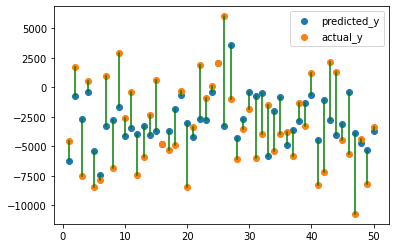

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(r2_score(y_test, y_pred))
plot(y_test=y_test, y_pred=y_pred)

Polynomial

3802.4619140625


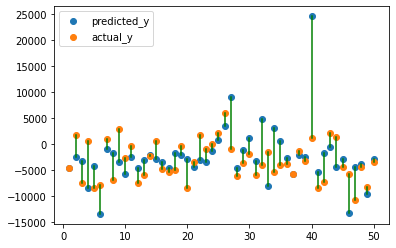

In [7]:
poly = PolynomialFeatures(degree=3, include_bias=True)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.transform(x_test)

#include bias parameter
lr = LinearRegression()
lr.fit(x_train_trans, y_train)
y_pred = lr.predict(x_test_trans)
print(mean_absolute_error(y_test, y_pred))
plot(y_test=y_test, y_pred=y_pred)

In [ ]:
Fill biological column

In [38]:
def get_all_people_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[['Age at CT', "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)']]
    n = ct_data.shape[0]
    all_people_ct_data = []

    for i in range(n):
        row = ct_data.loc[i]
        ignore = False
        for j in row:
          if pd.isna(j) or j == ' ': # There is an empty string somewhere in Liver column
            ignore = True
            break          

        if not ignore:
          all_people_ct_data.append(row)

    return np.array(all_people_ct_data, dtype=np.float32)

# dead_people_ct_data[0] -> biological age
# dead_people_ct_data[1:] -> ct_data


In [39]:
a = get_all_people_ct_data(oppScrData)

In [40]:
a[0]

array([5.5000000e+01, 1.9200000e+02, 4.8550287e+02, 6.9431427e+02,
       1.8349715e+02, 3.0200858e+02, 6.0758919e-01, 1.6150124e+01,
       1.2396874e+02, 4.8413189e+01, 2.7090640e+03, 5.2000000e+01],
      dtype=float32)

In [41]:
len(a)

8878

In [27]:
days_lost = -lr.predict(poly.fit_transform(a[:,1:]))

In [28]:
days_lost

array([3018.6987, 5572.9663, 1675.0815, ..., 6468.3003, 4548.519 ,
       1791.5034], dtype=float32)

In [29]:
a[:,0] = a[:,0]*365 + days_lost

In [30]:
a[0]

array([2.3093699e+04, 1.9200000e+02, 4.8550287e+02, 6.9431427e+02,
       1.8349715e+02, 3.0200858e+02, 6.0758919e-01, 1.6150124e+01,
       1.2396874e+02, 4.8413189e+01, 2.7090640e+03, 5.2000000e+01],
      dtype=float32)

In [32]:
a[:,0]/365

array([63.27041 , 67.2684  , 64.589264, ..., 80.721375, 67.4617  ,
       65.90823 ], dtype=float32)

In [33]:
X = a[:, 1:]
y = a[:,0]

In [34]:
X

array([[ 192.      ,  485.50287 ,  694.3143  , ...,   48.41319 ,
        2709.064   ,   52.      ],
       [ 256.      ,  490.05453 ,  706.0515  , ...,   50.101334,
           0.      ,   54.      ],
       [ 149.      ,  289.1081  ,  584.4892  , ...,   69.11585 ,
        2586.575   ,   57.      ],
       ...,
       [ 135.      ,  822.2872  , 1154.6051  , ...,   57.78635 ,
        1115.997   ,   45.      ],
       [ 219.      ,  418.2     ,  660.3461  , ...,   50.929787,
        3515.371   ,   44.      ],
       [ 151.      ,   61.54359 ,  362.88974 , ...,   29.688124,
        3015.129   ,   54.      ]], dtype=float32)

In [35]:
y

array([23093.7  , 24552.967, 23575.082, ..., 29463.3  , 24623.52 ,
       24056.504], dtype=float32)